<a href="https://colab.research.google.com/github/f247805/NLP/blob/main/BytePair%2BW2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:


from PyPDF2 import PdfReader

def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text

pdf_path = '/content/drive/MyDrive/NLP/Life 3.0_ Being Human in the Age of Artificial Intelligence.pdf'
text = extract_text_from_pdf(pdf_path)




In [20]:
import re
from PyPDF2 import PdfReader

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text

def clean_text(text):
    # Remove lines starting with keywords like "Table" or "Figure"
    text = re.sub(r'(^Table\s+\d+.*$|^Figure\s+\d+.*$)', '', text, flags=re.MULTILINE)

    # Remove any text that seems to be structured as a table
    text = re.sub(r'(\s+\|\s+|\s{4,})', ' ', text)

    # Remove brackets and their content
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets and content
    text = re.sub(r'\(.*?\)', '', text)  # Remove round brackets and content
    text = re.sub(r'\{.*?\}', '', text)  # Remove curly brackets and content

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove HTTP and HTTPS URLs
    text = re.sub(r'www\.\S+', '', text)  # Remove www URLs

    # Remove exclamation marks, question marks, and other punctuation except for periods
    text = re.sub(r'[!?\.,:;\'\"—]', '', text)

    # Remove single and double quotation marks except periods
    text = re.sub(r'[\'\"]', '', text)

    # Remove excessive whitespace (including new lines and multiple spaces)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'\n+', '\n', text)  # Replace multiple new lines with a single new line

    # Remove dots between words or characters (e.g., a.samnn -> asamnn) but keep sentence-ending dots
    text = re.sub(r'(?<=[a-zA-Z])\.(?=[a-zA-Z])', '', text)

    # Strip leading and trailing whitespace
    text = text.strip()

    return text

cleaned_text = clean_text(text)






In [10]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

# Example cleaned text
sentences = sent_tokenize(cleaned_text)
print(f"Number of sentences: {len(sentences)}")


# Split text into chunks
def split_text_into_chunks(text, num_chunks):
    chunk_size = len(text) // num_chunks
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
# Split text into 400 chunks (documents)
num_chunks = 200
documents = split_text_into_chunks(cleaned_text, num_chunks)


Number of sentences: 1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
!pip install subword-nmt

In [13]:
import subprocess

# Save cleaned text list to a file
input_file = '/content/drive/MyDrive/NLP/BPE_cleaned_text.txt'


bpe_output_file = '/content/drive/MyDrive/NLP/cleaned_text_bpe.txt'
codes_file = 'bpe.codes'
vocab_size = 5000  # Adjust as needed

# Apply BPE using subword-nmt
def apply_bpe(input_file, output_file, codes_file, vocab_size):
    # Learn BPE codes
    subprocess.run(['subword-nmt', 'learn-bpe', '-s', str(vocab_size), '-i', input_file, '-o', codes_file])

    # Apply BPE codes
    subprocess.run(['subword-nmt', 'apply-bpe', '-c', codes_file, '-i', input_file, '-o', output_file])

apply_bpe(input_file, bpe_output_file, codes_file, vocab_size)




In [15]:
import subprocess

def apply_bpe_to_file(input_file, output_file, codes_file):
    subprocess.run(['subword-nmt', 'apply-bpe', '-c', codes_file, '-i', input_file, '-o', output_file])

# Apply BPE to each chunk
for i, chunk in enumerate(documents):
    with open(f'chunk_{i}.txt', 'w') as file:
        file.write(chunk)

    apply_bpe_to_file(f'chunk_{i}.txt', f'bpe_chunk_{i}.txt', 'bpe.codes')


In [16]:
def read_bpe_file(file_path):
    with open(file_path, 'r') as file:
        return [line.strip().split() for line in file]

# Read BPE-encoded tokens from each chunk
tokenized_documents_bpe = []
for i in range(len(documents)):
    bpe_tokens = read_bpe_file(f'bpe_chunk_{i}.txt')
    tokenized_documents_bpe.extend(bpe_tokens)


In [17]:
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_documents_bpe, vector_size=100, window=5, min_count=1, workers=4)

# Get the embeddings for each unique word
word_vectors = model.wv
word_list = list(word_vectors.index_to_key)
embeddings = np.array([word_vectors[word] for word in word_list])

print(f"Number of words in vocabulary: {len(word_list)}")


num_sentences = len(tokenized_documents_bpe)
print(f"Number of sentences in the corpus: {num_sentences}")




Number of words in vocabulary: 5012
Number of sentences in the corpus: 201


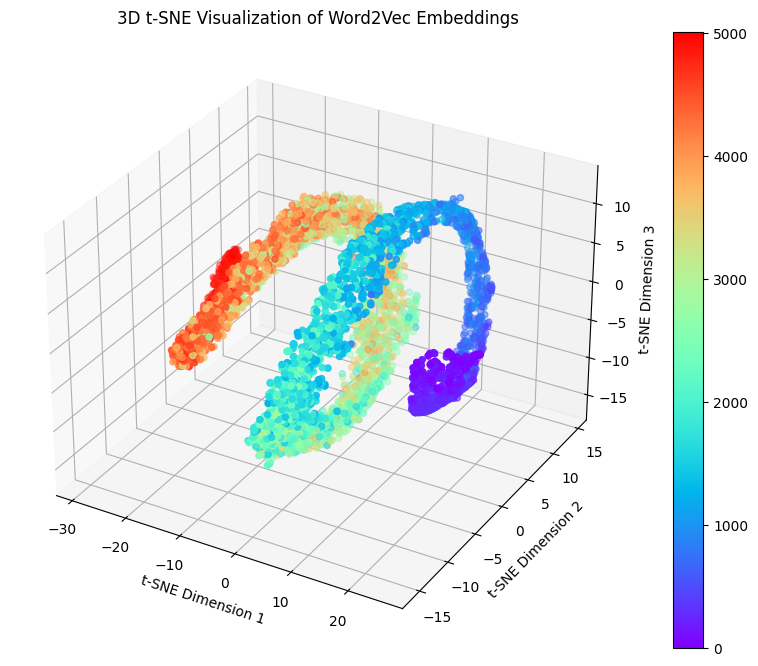

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=50, n_iter=2000)  # Adjust perplexity and n_iter as needed
tsne_result = tsne.fit_transform(embeddings)

def plot_3d_tsne(tsne_result, word_list):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Use a color map for the points
    scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=range(len(tsne_result)), cmap='rainbow')

    # Add color bar for better differentiation
    fig.colorbar(scatter, ax=ax)

    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    ax.set_title('3D t-SNE Visualization of Word2Vec Embeddings')
    plt.show()

# Plot the t-SNE results
plot_3d_tsne(tsne_result, word_list)
